In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from collections import Counter
import networkx as nx
import community

import sys
import localgraphclustering as lgc

# Making a SBM graph

In [166]:
npts

array([20, 20, 20, 20, 20])

In [237]:
p,q = 0.3,0.025
ncls = 5
cls_size = 20
npts = np.random.choice(range(cls_size,cls_size+1),ncls)
nnodes = np.sum(npts)
labels = np.zeros(nnodes,dtype="int32")
si = 0
for i in range(ncls):
    labels[si:(si+npts[i])] = i
    si += npts[i]

ei,ej = [],[]
np.random.seed(1911)
rands = np.random.rand(nnodes,nnodes)
for i in range(nnodes):
    for j in range(i+1,nnodes):
        if labels[i] == labels[j] and rands[i,j] < p:
            ei.append(i)
            ej.append(j)
        if labels[i] != labels[j] and rands[i,j] < q:
            ei.append(i)
            ej.append(j)
G = lgc.GraphLocal()
G.list_to_gl(ei,ej,[1.0]*len(ei))

# Computing graph layout

In [229]:
cls_center_loc = [(10*np.cos((i*1.0/ncls)*(2*np.pi)-(54/180)*(np.pi)),10*np.sin((i*1.0/ncls)*(2*np.pi)-(54/180)*(np.pi))) for i in range(ncls)]
init_coords = []
for k in range(ncls):
    npts_curr = npts[k]
    init_coords += [(cls_center_loc[k][0]+2*np.cos((i*1.0/npts_curr)*(2*np.pi)),cls_center_loc[k][1]+2*np.sin((i*1.0/npts_curr)*(2*np.pi))) for i in range(npts_curr)]
init_coords = {i:init_coords[i] for i in range(nnodes)}
nxG = nx.Graph()
nxG.add_nodes_from(range(nnodes))
nxG.add_edges_from(zip(ei,ej))
coords = nx.spring_layout(nxG,pos=init_coords,iterations=2,seed=0)
coords = [coords[i] for i in range(nnodes)]

# Visualizing the graph

In [101]:
# selected_color = [(127/255,201/255,127/255),
#                   (190/255,174/255,212/255),
#                   (253/255,192/255,134/255),
#                   (255/255,255/255,153/255),
#                   (56/255,108/255,176/255)]
selected_color = [(27/255,158/255,119/255),
                  (217/255,95/255,2/255),
                  (117/255,112/255,179/255),
                  (102/255,166/255,30/255),
                  (231/255,41/255,138/255)]
nodesize=12
figsize=2.5
xmin,ymin = np.min(np.array(coords),0)
xmax,ymax = np.max(np.array(coords),0)

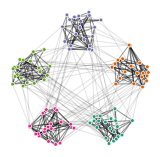

In [230]:
withinalpha=0.4
betweenalpha=0.1
drawing = G.draw(coords,figsize=(figsize,figsize),
                 nodecolor=[selected_color[i] for i in labels],
                 nodesize=nodesize,edgealpha=betweenalpha)   

for edge in drawing.edge_mapping.keys():
    if labels[edge[0]] == labels[edge[1]]:
        drawing.edgecolor(edge[0],edge[1],alpha=withinalpha)
    else:
        drawing.edgecolor(edge[0],edge[1],alpha=betweenalpha)
drawing.nodewidth(range(len(labels)),0.5)        
drawing.nodecolor(range(len(labels)),edgecolor='w')
plt.autoscale(enable=True, axis='x', tight=True)
plt.autoscale(enable=True, axis='y', tight=True)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.gcf().savefig("sbm-example.pdf",bbox_inches='tight',pad_inches=0,transparent=True)
plt.gcf().savefig("sbm-example.png",bbox_inches='tight',pad_inches=0,transparent=True,dpi=600)
plt.show()

# Running Louvian's method

In [233]:
partition = community.best_partition(nxG,random_state=6)
louvian_colors = [partition[i] for i in range(nnodes)]
louvian_colors = np.array(louvian_colors)
community.modularity(partition,nxG)

0.523123361314914

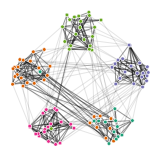

In [234]:
withinalpha=0.4
betweenalpha=0.1
drawing = G.draw(coords,figsize=(figsize,figsize),
                 nodecolor=[selected_color[i] for i in louvian_colors],
                 nodesize=nodesize,edgealpha=betweenalpha)   

for edge in drawing.edge_mapping.keys():
    if louvian_colors[edge[0]] == louvian_colors[edge[1]]:
        drawing.edgecolor(edge[0],edge[1],alpha=withinalpha)
    else:
        drawing.edgecolor(edge[0],edge[1],alpha=betweenalpha)
drawing.nodewidth(range(len(labels)),0.5)        
drawing.nodecolor(range(len(labels)),edgecolor='w')
plt.autoscale(enable=True, axis='x', tight=True)
plt.autoscale(enable=True, axis='y', tight=True)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.gcf().savefig("sbm-example-louvain.pdf",bbox_inches='tight',pad_inches=0,transparent=True)
plt.gcf().savefig("sbm-example-louvain.png",bbox_inches='tight',pad_inches=0,transparent=True,dpi=600)
plt.show()

# Running MQI method

In [235]:
mqi_colors = np.zeros(nnodes,dtype="int32")-1
for cls in Counter(louvian_colors).most_common(ncls):
    i = cls[0]
    seeds = np.nonzero(louvian_colors==i)[0]
    #seeds = lgc.flow_clustering(G,seeds,method="mqi")[0]
    neigh = np.nonzero(np.asarray(np.sum(G.adjacency_matrix[seeds,:],0))[0])[0]
    seeds = list(set(seeds).union(neigh))
    flow_output = lgc.flow_clustering(G,seeds,method="mqi")[0]
    mqi_colors[flow_output] = i

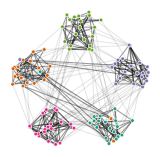

In [236]:
withinalpha=0.4
betweenalpha=0.1
drawing = G.draw(coords,figsize=(figsize,figsize),
                 nodecolor=[selected_color[i] for i in mqi_colors],
                 nodesize=nodesize,edgealpha=betweenalpha)   

for edge in drawing.edge_mapping.keys():
    if mqi_colors[edge[0]] == mqi_colors[edge[1]]:
        drawing.edgecolor(edge[0],edge[1],alpha=withinalpha)
    else:
        drawing.edgecolor(edge[0],edge[1],alpha=betweenalpha)
drawing.nodewidth(range(len(labels)),0.5)        
drawing.nodecolor(range(len(labels)),edgecolor='w')
plt.autoscale(enable=True, axis='x', tight=True)
plt.autoscale(enable=True, axis='y', tight=True)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.gcf().savefig("sbm-example-mqi.pdf",bbox_inches='tight',pad_inches=0,transparent=True)
plt.gcf().savefig("sbm-example-mqi.png",bbox_inches='tight',pad_inches=0,transparent=True,dpi=600)
plt.show()